In [6]:
# ======================================================
#  CELL 1: DATA PREPARATION (Auto-Find Paths)
#  This script finds the correct paths and
#  creates simple image/mask folders.
# ======================================================
import os
import cv2
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from tqdm.notebook import tqdm
import glob # Import the 'glob' library to search for files

print("Searching for dataset files... this may take a moment.")

# --- 1. Find the annotation file automatically ---
# We will search inside your dataset folder for the file.
search_path = '/kaggle/input/coco-2017-dataset/**/instances_val2017.json'
# recursive=True lets it search in all subfolders
files_found = glob.glob(search_path, recursive=True)

if not files_found:
    print("\n\n!!! CRITICAL ERROR !!!")
    print("Could not find 'instances_val2017.json' anywhere in /kaggle/input/coco-2017-dataset/")
    print("Please check that you added the correct 'COCO 2017 Dataset'.")
    # Stop the script by raising an error
    raise FileNotFoundError("Could not find 'instances_val2017.json'")

# --- 2. Set the correct paths based on the file we found ---
# We found the file!
ANN_IN_FILE = files_found[0]
# The 'annotations' folder is one level up from the file
ANNOTATIONS_DIR = os.path.dirname(ANN_IN_FILE)
# The dataset 'root' is one level up from the 'annotations' folder
DATASET_ROOT = os.path.dirname(ANNOTATIONS_DIR)
# The image folder is in the same 'root', under 'val2017'
IMG_IN_DIR = os.path.join(DATASET_ROOT, 'val2017')

print(f"\n--- Paths Found Successfully! ---")
print(f"Using Image Dir: {IMG_IN_DIR}")
print(f"Using Ann File: {ANN_IN_FILE}")
print("---------------------------------")

# --- 3. Define Output Paths ---
# Output paths (where your script will read from)
IMG_OUT_DIR = "/kaggle/working/seg_demo/images"
MASK_OUT_DIR = "/kaggle/working/seg_demo/masks"

# Create the output directories
os.makedirs(IMG_OUT_DIR, exist_ok=True)
os.makedirs(MASK_OUT_DIR, exist_ok=True)

# --- 4. Load COCO Annotations ---
print(f"Loading annotations from {ANN_IN_FILE}...")
coco = COCO(ANN_IN_FILE)
print("Annotations loaded.")

# --- 5. Get 1000 Images for this Demo ---
image_ids = coco.getImgIds()[:1000]
print(f"Preparing 1000 images...")

# --- 6. Loop, Process, and Save ---
for img_id in tqdm(image_ids):
    # --- Load Image ---
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_IN_DIR, img_info['file_name'])
    
    try:
        image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"Warning: could not find {img_path}, skipping.")
        continue

    # --- Find Main Subject Mask ---
    annIds = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(annIds)
    
    main_subject_mask_np = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    
    if anns:
        # Find the annotation with the largest area
        largest_ann = max(anns, key=lambda x: x['area'])
        main_subject_mask_np = coco.annToMask(largest_ann)

    # Convert binary mask (0, 1) to (0, 255) and save as PIL image
    mask_pil = Image.fromarray(main_subject_mask_np * 255, mode='L')
    
    # --- Save to new simple directories ---
    base_filename = f"{img_id:012d}"
    img_out_path = os.path.join(IMG_OUT_DIR, base_filename + ".jpg")
    mask_out_path = os.path.join(MASK_OUT_DIR, base_filename + ".png")
    
    image.save(img_out_path)
    mask_pil.save(mask_out_path)

print("\n--- Data Preparation Complete! ---")
print(f"Images saved to: {IMG_OUT_DIR}")
print(f"Masks saved to: {MASK_OUT_DIR}")

Searching for dataset files... this may take a moment.

--- Paths Found Successfully! ---
Using Image Dir: /kaggle/input/coco-2017-dataset/coco2017/val2017
Using Ann File: /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json
---------------------------------
Loading annotations from /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json...
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Annotations loaded.
Preparing 1000 images...


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_48/3221408626.py:86: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(main_subject_mask_np * 255, mode='L')



--- Data Preparation Complete! ---
Images saved to: /kaggle/working/seg_demo/images
Masks saved to: /kaggle/working/seg_demo/masks


Using device: cpu
Loading images from: /kaggle/working/seg_demo/images


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 0.5065


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 0.4726


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 0.4648


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 0.4599


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 0.4561
Visualizing 20 predictions...


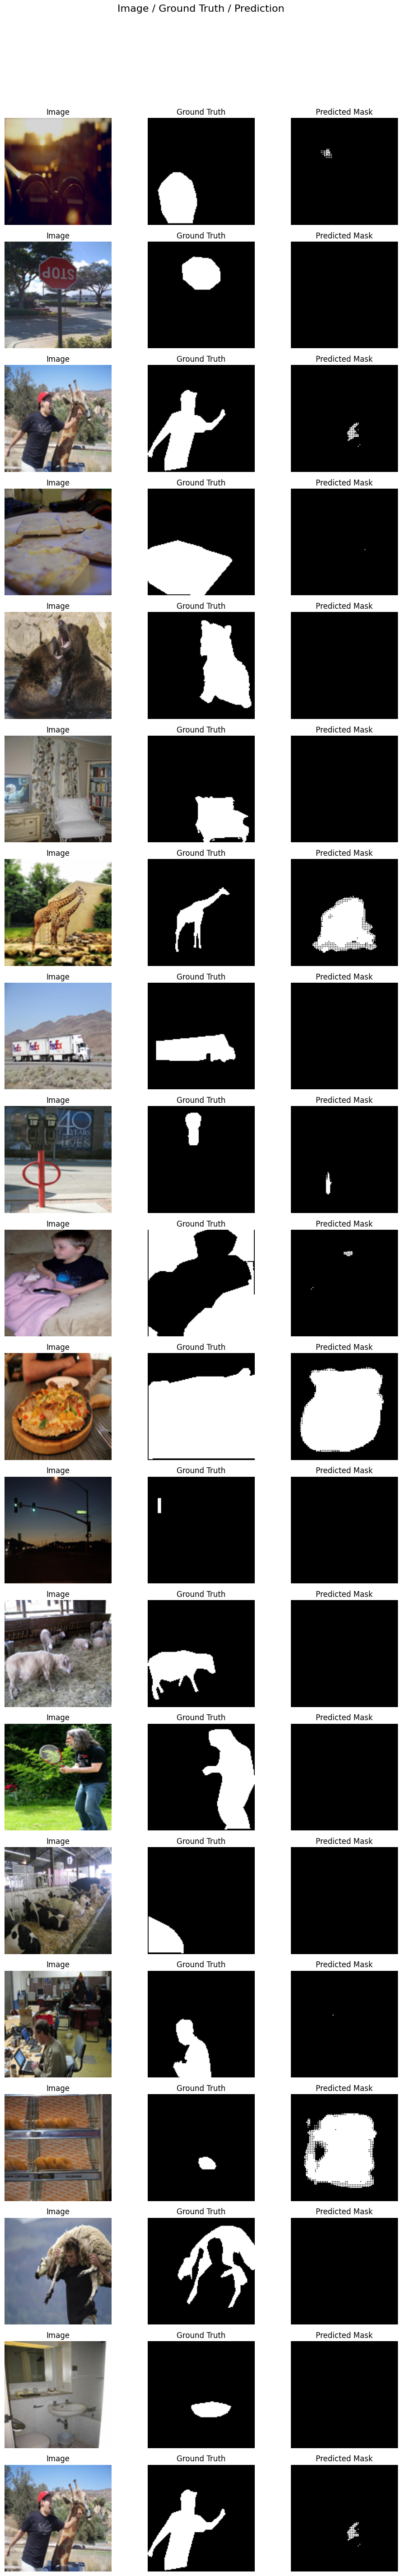

In [7]:
# ======================================================
#  CELL 2: YOUR SCRIPT (Now it will work!)
# ======================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm.notebook for Kaggle

# ======================================================
# 1️⃣  PATHS - These now point to the files Cell 1 created
# ======================================================
train_img_dir = "/kaggle/working/seg_demo/images"
train_mask_dir = "/kaggle/working/seg_demo/masks"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
print(f"Loading images from: {train_img_dir}")

# ======================================================
# 2️⃣  DATASET CLASS (Exactly as you provided)
# ======================================================
class CocoBinaryMaskDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform # Note: This script doesn't use this, but it's fine.
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        
        # Make sure images and masks match
        # (This is a small fix to prevent errors)
        self.images = [f for f in self.images if f.replace('.jpg','.png') in self.masks]
        self.masks = [f.replace('.jpg','.png') for f in self.images]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        # Construct mask path from image path
        mask_name = self.images[idx].replace('.jpg','.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = image.resize((128, 128))
        mask = mask.resize((128, 128))

        # This part is your custom transform
        image_np = np.array(image) / 255.0
        mask_np = np.array(mask)
        mask_np = (mask_np > 127).astype(np.float32) # Binarize the mask

        image_tensor = torch.tensor(image_np, dtype=torch.float32).permute(2, 0, 1)
        mask_tensor = torch.tensor(mask_np, dtype=torch.float32).unsqueeze(0)

        return image_tensor, mask_tensor

# ======================================================
# 3️⃣  U-NET MODEL (Exactly as you provided)
# ======================================================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False), # Added bias=False
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False), # Added bias=False
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super().__init__()
        self.down1 = DoubleConv(in_c, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.bottom = DoubleConv(256, 512)
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, out_c, 1)
    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        b = self.bottom(p3)
        u1 = self.up1(b)
        u1 = torch.cat([u1, d3], dim=1)
        u1 = self.conv1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        u3 = self.conv3(u3)
        return self.final_conv(u3)

# ======================================================
# 4️⃣  TRAINING SETUP (Exactly as you provided)
# ======================================================
dataset = CocoBinaryMaskDataset(train_img_dir, train_mask_dir)
loader = DataLoader(dataset, batch_size=8, shuffle=True) # Batch size 8 is a good start

model = UNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss() # This is perfect for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ======================================================
# 5️⃣  TRAIN LOOP (5 EPOCHS - Fast!)
# ======================================================
epochs = 5 # Changed to 5 for a fast test run
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss/len(loader):.4f}")

# ======================================================
# 6️⃣  VISUALIZE OUTPUTS (Exactly as you provided)
# ======================================================
print("Visualizing 20 predictions...")
model.eval()
num_images = 20
fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
fig.suptitle("Image / Ground Truth / Prediction", fontsize=16)

for i in range(num_images):
    # Get a new random image from the dataset
    idx = np.random.randint(0, len(dataset))
    image, mask = dataset[idx] # Get item from dataset
    
    # Prepare for model
    image_tensor_unsqueezed = image.unsqueeze(0).to(DEVICE) 
    
    with torch.no_grad():
        pred_logits = model(image_tensor_unsqueezed)
        pred_prob = torch.sigmoid(pred_logits) # Convert logits to probabilities
        pred_mask = (pred_prob > 0.5).float().cpu().squeeze().numpy() # Binarize

    # Prepare for plotting
    image_to_plot = image.permute(1, 2, 0).numpy() # (C,H,W) -> (H,W,C)
    mask_to_plot = mask.squeeze().numpy() # (1,H,W) -> (H,W)
    
    axes[i, 0].imshow(image_to_plot)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_to_plot, cmap="gray")
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_mask, cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()